<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold_wJackhmmer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlphaFold2 w/ Jackhmmer
This notebook modifies deepmind's [original notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) to add experimental homooligomer support.

See [ColabFold]() for other related notebooks

In [ ]:
#@title Install third-party software
#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      %shell sudo apt install --quiet --yes hmmer
      pbar.update(6)

      # Install py3dmol.
      %shell pip install py3dmol
      pbar.update(2)

      # Install OpenMM and pdbfixer.
      %shell rm -rf /opt/conda
      %shell wget -q -P /tmp \
        https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
          && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
          && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
      pbar.update(9)

      PATH=%env PATH
      %env PATH=/opt/conda/bin:{PATH}
      %shell conda update -qy conda \
          && conda install -qy -c conda-forge \
            python=3.7 \
            openmm=7.5.1 \
            pdbfixer
      pbar.update(80)

      # Create a ramdisk to store a database chunk to make Jackhmmer run fast.
      %shell sudo mkdir -m 777 --parents /tmp/ramdisk
      %shell sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk
      pbar.update(2)

      %shell wget -q -P /content \
        https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
      pbar.update(1)
except subprocess.CalledProcessError:
  print(captured)
  raise

In [ ]:
#@title Download AlphaFold

#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left.

GIT_REPO = 'https://github.com/deepmind/alphafold'

SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      %shell rm -rf alphafold
      %shell git clone {GIT_REPO} alphafold
      pbar.update(8)
      %shell pip3 install ./alphafold
      pbar.update(10)

      # Apply OpenMM patch.
      %shell pushd /opt/conda/lib/python3.7/site-packages/ && \
          patch -p0 < /content/alphafold/docker/openmm.patch && \
          popd
          
      %shell mkdir -p /content/alphafold/common
      %shell cp -f /content/stereo_chemical_props.txt /content/alphafold/common

      %shell mkdir --parents "{PARAMS_DIR}"
      %shell wget -O "{PARAMS_PATH}" "{SOURCE_URL}"
      pbar.update(27)

      %shell tar --extract --verbose --file="{PARAMS_PATH}" \
        --directory="{PARAMS_DIR}" --preserve-permissions
      %shell rm "{PARAMS_PATH}"
      pbar.update(55)
except subprocess.CalledProcessError:
  print(captured)
  raise

import jax
if jax.local_devices()[0].platform == 'tpu':
  raise RuntimeError('Colab TPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')
elif jax.local_devices()[0].platform == 'cpu':
  raise RuntimeError('Colab CPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')

## Making a prediction

Please paste the sequence of your protein in the text box below, then run the remaining cells via _Runtime_ > _Run after_. You can also run the cells individually by pressing the _Play_ button on the left.

Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab (see FAQ below).

In [ ]:
#@title Enter the amino acid sequence to fold ⬇️
sequence = 'MNPYIYLGGAILAEVIGTTLMKFSEGFTRLWPSVGTIICYCASFWLLAQTLAYIPTGIAYAIWSGVGIVLISLLSWGFFGQRLDLPAIIGMMLICAGVLIINLLSRSTPH'  #@param {type:"string"}

MIN_SEQUENCE_LENGTH = 16
MAX_SEQUENCE_LENGTH = 2500

# Remove all whitespaces, tabs and end lines; upper-case
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
save_all_models = True 
save_msa = True 
#@markdown ### Experimental options
homooligomer = 2 #@param [1,2,3,4,5,6,7,8] {type:"raw"}


aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
if not set(sequence).issubset(aatypes):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. AlphaFold only supports 20 standard amino acids as inputs.')
if len(sequence)*homooligomer < MIN_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too short: {len(sequence)} amino acids, while the minimum is {MIN_SEQUENCE_LENGTH}')
if len(sequence)*homooligomer > MAX_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too long: {len(sequence)} amino acids, while the maximum is {MAX_SEQUENCE_LENGTH}. Please use the full AlphaFold system for long sequences.')


14836 Sequences Found in uniref90
853 Sequences Found in smallbfd
498 Sequences Found in mgnify

16060 Sequences Found in Total



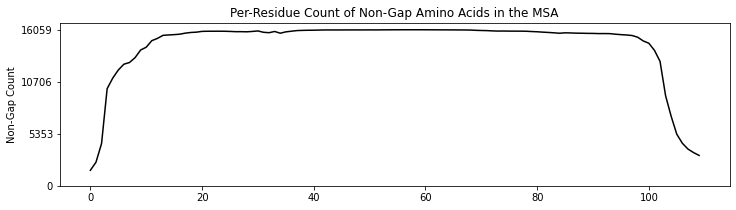

In [ ]:
#@title Search against genetic databases
#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by AlphaFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.
# --- Python imports ---
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')

import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from urllib import request
from concurrent import futures
from google.colab import files
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

# Color bands for visualizing plddt
PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

# --- Find the closest source ---
test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
ex = futures.ThreadPoolExecutor(3)
def fetch(source):
  request.urlretrieve(test_url_pattern.format(source))
  return source
fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
source = None
for f in futures.as_completed(fs):
  source = f.result()
  ex.shutdown()
  break

# --- Search against genetic databases ---
with open('target.fasta', 'wt') as f:
  f.write(f'>query\n{sequence}')

# Run the search against chunks of genetic databases (since the genetic
# databases don't fit in Colab ramdisk).

jackhmmer_binary_path = '/usr/bin/jackhmmer'
dbs = []

num_jackhmmer_chunks = {'uniref90': 59, 'smallbfd': 17, 'mgnify': 71}
total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())
with tqdm.notebook.tqdm(total=total_jackhmmer_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
  def jackhmmer_chunk_callback(i):
    pbar.update(n=1)

  pbar.set_description('Searching uniref90')
  jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/uniref90_2021_03.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['uniref90'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=135301051)
  dbs.append(('uniref90', jackhmmer_uniref90_runner.query('target.fasta')))

  pbar.set_description('Searching smallbfd')
  jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/bfd-first_non_consensus_sequences.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['smallbfd'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=65984053)
  dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query('target.fasta')))

  pbar.set_description('Searching mgnify')
  jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/mgy_clusters_2019_05.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['mgnify'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=304820129)
  dbs.append(('mgnify', jackhmmer_mgnify_runner.query('target.fasta')))


# --- Extract the MSAs and visualize ---
# Extract the MSAs from the Stockholm files.
# NB: deduplication happens later in pipeline.make_msa_features.

mgnify_max_hits = 501

msas = []
deletion_matrices = []
full_msa = []
for db_name, db_results in dbs:
  unsorted_results = []
  for i, result in enumerate(db_results):
    msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
    e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
    e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
    zipped_results = zip(msa, deletion_matrix, target_names, e_values)
    if i != 0:
      # Only take query from the first chunk
      zipped_results = [x for x in zipped_results if x[2] != 'query']
    unsorted_results.extend(zipped_results)
  sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
  db_msas, db_deletion_matrices, _, _ = zip(*sorted_by_evalue)
  if db_msas:
    if db_name == 'mgnify':
      db_msas = db_msas[:mgnify_max_hits]
      db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
    full_msa.extend(db_msas)
    msas.append(db_msas)
    deletion_matrices.append(db_deletion_matrices)
    msa_size = len(set(db_msas))
    print(f'{msa_size} Sequences Found in {db_name}')

deduped_full_msa = list(dict.fromkeys(full_msa))
total_msa_size = len(deduped_full_msa)
print(f'\n{total_msa_size} Sequences Found in Total\n')

aa_map = {restype: i for i, restype in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ-')}
msa_arr = np.array([[aa_map[aa] for aa in seq] for seq in deduped_full_msa])
num_alignments, num_res = msa_arr.shape

if save_msa:
  pickle.dump({"msas":msas,"deletion_matrices":deletion_matrices},
              open("predictions/msa.pickle","wb"))

fig = plt.figure(figsize=(12, 3))
plt.title('Per-Residue Count of Non-Gap Amino Acids in the MSA')
plt.plot(np.sum(msa_arr != aa_map['-'], axis=0), color='black')
plt.ylabel('Non-Gap Count')
plt.yticks(range(0, num_alignments + 1, max(1, int(num_alignments / 3))))
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

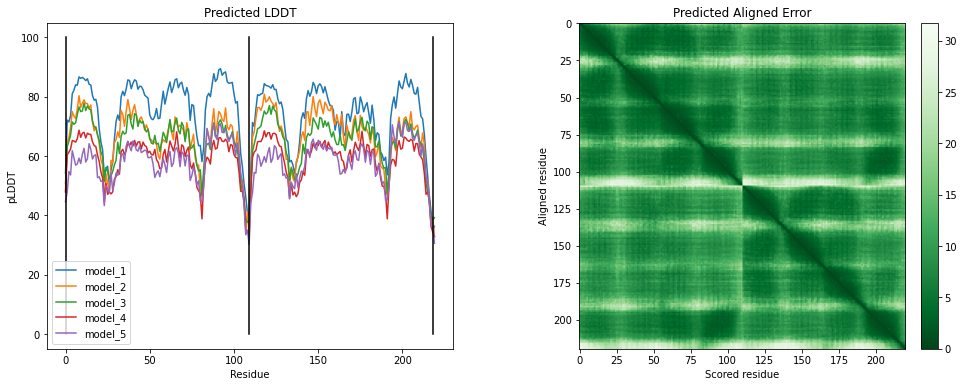

In [ ]:
#@title Run AlphaFold and download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

# --- Run the model ---
from string import ascii_uppercase

def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros([num_templates_, num_res_, 22], np.float32),
      'template_all_atom_masks': np.zeros([num_templates_, num_res_, 37, 3], np.float32),
      'template_all_atom_positions': np.zeros([num_templates_, num_res_, 37], np.float32),
      'template_domain_names': np.zeros([num_templates_], np.float32),
      'template_sum_probs': np.zeros([num_templates_], np.float32),
  }

num_templates = 0
num_res = len(sequence)

if homooligomer == 1:
  msas_mod = msas
  deletion_matrices_mod = deletion_matrices
else:
  msas_mod = []
  deletion_matrices_mod = []
  for o in range(homooligomer):
    L = num_res * o
    R = num_res * (homooligomer-(o+1))
    for msa,deletion_matrix in zip(msas,deletion_matrices):
      msas_mod.append(["-"*L+seq+"-"*R for seq in msa])
      deletion_matrices_mod.append([[0]*L+mtx+[0]*R for mtx in deletion_matrix])


feature_dict = {}
feature_dict.update(pipeline.make_sequence_features(sequence*homooligomer, 'test', num_res*homooligomer))
feature_dict.update(pipeline.make_msa_features(msas_mod, deletion_matrices=deletion_matrices_mod))
feature_dict.update(_placeholder_template_feats(num_templates, num_res*homooligomer))

# Minkyung's code
# add big enough number to residue index to indicate chain breaks
idx_res = feature_dict['residue_index']
L_prev = 0
Ls = [num_res]*homooligomer
for L_i in Ls[:-1]:
  idx_res[L_prev+L_i:] += 200
  L_prev += L_i  
chains = list("".join([ascii_uppercase[n]*L for n,L in enumerate(Ls)]))
feature_dict['residue_index'] = idx_res

output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

plddts = {}
pae_outputs = {}
unrelaxed_proteins = {}

model_names = ['model_5', 'model_1', 'model_2', 'model_3', 'model_4']
with tqdm.notebook.tqdm(total=len(model_names)+int(homooligomer==1), bar_format=TQDM_BAR_FORMAT) as pbar:
  for num,model_name in enumerate(model_names):
    pbar.set_description(f'Running model_{num+1}')

    cfg = config.model_config(model_name+"_ptm")
    params = data.get_model_haiku_params(model_name+"_ptm", './alphafold/data')
    if model_name == "model_5":
      model_runner = model.RunModel(cfg, params)
    else:
      for k in model_runner.params.keys():
        model_runner.params[k] = params[k]

    processed_feature_dict = model_runner.process_features(feature_dict,random_seed=0)
    prediction_result = model_runner.predict(processed_feature_dict)    
    del params

    mean_plddt = prediction_result['plddt'].mean()

    # Get the pLDDT confidence metrics.
    pae_outputs[model_name] = (
        prediction_result['predicted_aligned_error'],
        prediction_result['max_predicted_aligned_error']
    )
    plddts[model_name] = prediction_result['plddt']

    # Set the b-factors to the per-residue plddt.
    final_atom_mask = prediction_result['structure_module']['final_atom_mask']
    b_factors = prediction_result['plddt'][:, None] * final_atom_mask
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,
                                                prediction_result,
                                                b_factors=b_factors)
    unrelaxed_proteins[model_name] = unrelaxed_protein

    # Delete unused outputs to save memory.
    del prediction_result
    pbar.update(n=1)

  del model_runner
  # Find the best model according to the mean pLDDT.
  model_rank = list(plddts.keys())
  model_rank = [model_rank[i] for i in np.argsort([plddts[x].mean() for x in model_rank])[::-1]]

  # --- AMBER relax the best model ---
  if homooligomer == 1:
    pbar.set_description(f'AMBER relaxation')
    amber_relaxer = relax.AmberRelaxation(
        max_iterations=0,
        tolerance=2.39,
        stiffness=10.0,
        exclude_residues=[],
        max_outer_iterations=20)
    best_pdb_lines, _, _ = amber_relaxer.process(prot=unrelaxed_proteins[model_rank[0]])
    pbar.update(n=1)  # Finished AMBER relax.
  else:
    best_pdb_lines = protein.to_pdb(best_model)

# Write out the prediction
best_pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
with open(best_pred_output_path, 'w') as f:
  for line in best_pdb_lines.splitlines():
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      seq_id = np.where(idx_res == seq_id)[0][0]
      f.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{plddts[model_rank[0]][seq_id]:6.2f}{line[66:]}\n")

if save_all_models:
  for n,name in enumerate(model_rank):
    pred_output_path = os.path.join(output_dir,f'model_{n+1}_unrelaxed.pdb')
    pdb_lines = protein.to_pdb(unrelaxed_proteins[name])
    with open(pred_output_path, 'w') as f:
      for line in pdb_lines.splitlines():
        if line[0:6] == "ATOM  ":
          seq_id = int(line[22:26].strip()) - 1
          seq_id = np.where(idx_res == seq_id)[0][0]
          f.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{plddts[name][seq_id]:6.2f}{line[66:]}\n")

############################################################
############################################################

############################################################
############################################################

# Display pLDDT and predicted aligned error (if output by the model).
if pae_outputs:
  num_plots = 2
else:
  num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
if save_all_models:
  for n,k in enumerate(model_rank):
    plt.plot(plddts[k],label=f"model_{n+1}")
else:
  plt.plot(plddts[model_rank[0]])
for n in range(homooligomer+1):
  x = n*(len(sequence)-1)
  plt.plot([x,x],[0,100],color="black")
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')
if save_all_models:
  plt.legend()

if num_plots == 2:
  plt.subplot(1, 2, 2)
  pae, max_pae = pae_outputs[model_rank[0]]
  plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.title('Predicted Aligned Error')
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

# Save pLDDT and predicted aligned error (if it exists)
pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
if pae_outputs:
  # Save predicted aligned error in the same format as the AF EMBL DB
  rounded_errors = np.round(pae.astype(np.float64), decimals=1)
  indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
  indices_1 = indices[0].flatten().tolist()
  indices_2 = indices[1].flatten().tolist()
  pae_data = json.dumps([{
      'residue1': indices_1,
      'residue2': indices_2,
      'distance': rounded_errors.flatten().tolist(),
      'max_predicted_aligned_error': max_pae.item()
  }],
                        indent=None,
                        separators=(',', ':'))
  with open(pae_output_path, 'w') as f:
    f.write(pae_data)


# --- Download the predictions ---
!zip -q -r {output_dir}.zip {output_dir}
files.download(f'{output_dir}.zip')

In [ ]:
#@title Display 3D structure

import ipywidgets
from ipywidgets import interact
def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = ['Very low (pLDDT < 50)','Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)','Very high (pLDDT > 90)']
  plt.figure(figsize=(2, 2))
  for c in ["#FF0000","#FFFF00","#00FFFF","#0000FF"]: plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([]); plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt

def show_pdb(show_sidechains, show_mainchain, color):
  view = py3Dmol.view(width=800, height=600)
  view.addModel(open(best_pred_output_path,'r').read(),'pdb')
  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(homooligomer),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchain:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  if color == "lDDT":
    grid = GridspecLayout(1, 2)
    out = Output()
    with out: view.show()
    grid[0, 0] = out
    out = Output()
    with out: plot_plddt_legend().show()
    grid[0, 1] = out
    return display.display(grid)
  else:
    return view.show()

interact(show_pdb,
         show_sidechains=ipywidgets.Checkbox(value=False),
         show_mainchain=ipywidgets.Checkbox(value=False),
         color=ipywidgets.Dropdown(options=['rainbow', 'lDDT', 'chain'], value='lDDT'))


interactive(children=(Checkbox(value=False, description='show_sidechains'), Checkbox(value=False, description=…

<function __main__.show_pdb>